## Analysing MNIST image dataset using Scarf

In [1]:
%load_ext autotime
%config InlineBackend.figure_format = 'retina'

import scarf
import matplotlib.pyplot as plt
import pandas as pd
scarf.__version__

'0.11.0'

time: 1.64 s (started: 2021-08-02 17:59:53 +02:00)


---
### 1) Fetch MNIST dataset and convert to Zarr format

The MNIST datasets consists of 60K grayscale images (28x28 pixel) of handwritten digits (0 through 9).
These can be unraveled such that each digit is described by a 784 dimensional vector. 
This dataset is  available to download through Scarf. We saved this data in the same format as
the output of cellranger pipeline with the matrix saved in MTX format.

In [2]:
scarf.fetch_dataset('lecun_60K_mnist_images', save_path='scarf_datasets')

INFO: Download finished! File saved here: C:\Users\parashar\Desktop\scarf_vignettes\dev\scarf_datasets\lecun_60K_mnist_images\barcodes.tsv.gz


INFO: Download finished! File saved here: C:\Users\parashar\Desktop\scarf_vignettes\dev\scarf_datasets\lecun_60K_mnist_images\features.tsv.gz


INFO: Download finished! File saved here: C:\Users\parashar\Desktop\scarf_vignettes\dev\scarf_datasets\lecun_60K_mnist_images\matrix.mtx.gz
time: 16 s (started: 2021-08-02 17:59:55 +02:00)


In [3]:
reader = scarf.CrDirReader('scarf_datasets/lecun_60K_mnist_images', 'rna')
writer = scarf.CrToZarr(
    reader,
    zarr_fn='scarf_datasets/lecun_60K_mnist_images/data.zarr',
    chunk_size=(2000, 1000),
)
writer.dump(batch_size=1000)

  0%|                                                                                                         …

time: 5.56 s (started: 2021-08-02 18:00:11 +02:00)


---
### 2) Load the Zarr file into the DataStore object

In [4]:
ds = scarf.DataStore(
    'scarf_datasets/lecun_60K_mnist_images/data.zarr',
    min_cells_per_feature=1000,
    min_features_per_cell=10,
    nthreads=4,
)
ds

(RNA) Computing nCells and dropOuts:   0%|                                                                    …

(RNA) Computing nCounts:   0%|                                                                                …

(RNA) Computing nFeatures:   0%|                                                                              …

DataStore has 60000 (60000) cells with 1 assays: RNA
   Cell metadata:
            'I', 'ids', 'names', 'RNA_nCounts', 'RNA_nFeatures', 
          
   RNA assay has 467 (784) features and following metadata:
            'I', 'ids', 'names', 'dropOuts', 'nCells', 
          

time: 843 ms (started: 2021-08-02 18:00:16 +02:00)


The labels for each image are embedded in their names. We will extract them add them as a separate column in *cells* attribute table

In [5]:
ds.cells.insert('digit_label',
                [int(x.rsplit('_', 1)[-1])-1 for x
                 in ds.cells.fetch_all('names')], overwrite=True)

time: 63 ms (started: 2021-08-02 18:00:17 +02:00)


---
### 3) Creating neighbourhood graph

We will not perform any cell filtering here. We will also skip feature selection step and will use all the valid features. Since, we imported the data as an RNAassay, PCA will be performed on the data. Before we begin the graph creation step, we will turn off the default normlization for an RNAassay.

Normalizing with feature subset:   0%|                                                                        …

Writing data to normed__I__I/data:   0%|                                                                      …

Calculating mean of norm. data:   0%|                                                                         …

Calculating std. dev. of norm. data:   0%|                                                                    …

Fitting PCA:   0%|                                                                                            …

Fitting ANN:   0%|                                                                                            …

Fitting kmeans:   0%|                                                                                         …

Estimating seed partitions:   0%|                                                                             …

Saving KNN graph:   0%|                                                                                       …

Smoothening KNN distances:   0%|                                                                              …

INFO: ANN recall: 100.00%


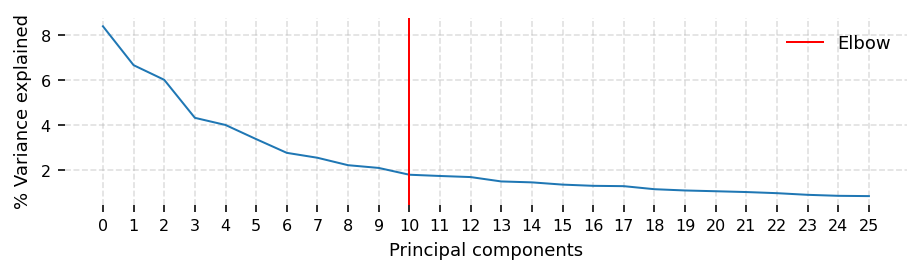

time: 43.8 s (started: 2021-08-02 18:00:17 +02:00)


In [6]:
# Set normalization method to a dummy function that returns unnormalized data
ds.RNA.normMethod = scarf.assay.norm_dummy

ds.make_graph(feat_key='I', k=31, dims=25, n_centroids=100, show_elbow_plot=True)

The elbow plot above suggests that taking first 10 PC dimensions might have been optimal this dataset. We wanted to capture even the very fine difference (at risk of larger noise) between the digits and hence do not rerun this with `dims=10`

---
### 3) UMAP embedding and clustering

We will now generate a 2D embedding of the neighbourhood graph of the MNIST images. This will allow to to acertain visually, how accurate Scarf was in estimating the underlying manifold of this dataset. There are two critical differences between calling UMAP from with Scarf and directly from UMAP library:
- When calling from Scarf, only the neighbourhood graph is provided to the core UMAP algorithm rather a normalized/scaled/reduced data matrix.
- Scarf performs a Kmeans clustering while identifying neighbours, this allows Scarf to generate an informed initial embedding coordinates for the data based on the KMeans centroids. UMAP package, on the other hand, calculates spectral layout for the graph.

In [7]:
ds.run_umap(n_epochs=300, spread=1, min_dist=0.05, parallel=True)

  0%|          | 0/300 [00:00<?, ?it/s]

time: 36.8 s (started: 2021-08-02 18:01:01 +02:00)


Before we visualize the UMAP embeddings, we will also perform clustering on the data (neighbourhood graph) using the default Paris algorithm. Here we choose to perform overclustering of the data so that we can capture fine differences within the individual digit classes.

In [8]:
ds.run_clustering(n_clusters=20)

time: 11.8 s (started: 2021-08-02 18:01:38 +02:00)


Relabeling the cluster ids to match their corresponding digit labels

In [9]:
ds.smart_label(
    to_relabel='RNA_cluster',
    base_label='digit_label',
    new_col_name='cluster_label',
)

time: 63 ms (started: 2021-08-02 18:01:50 +02:00)


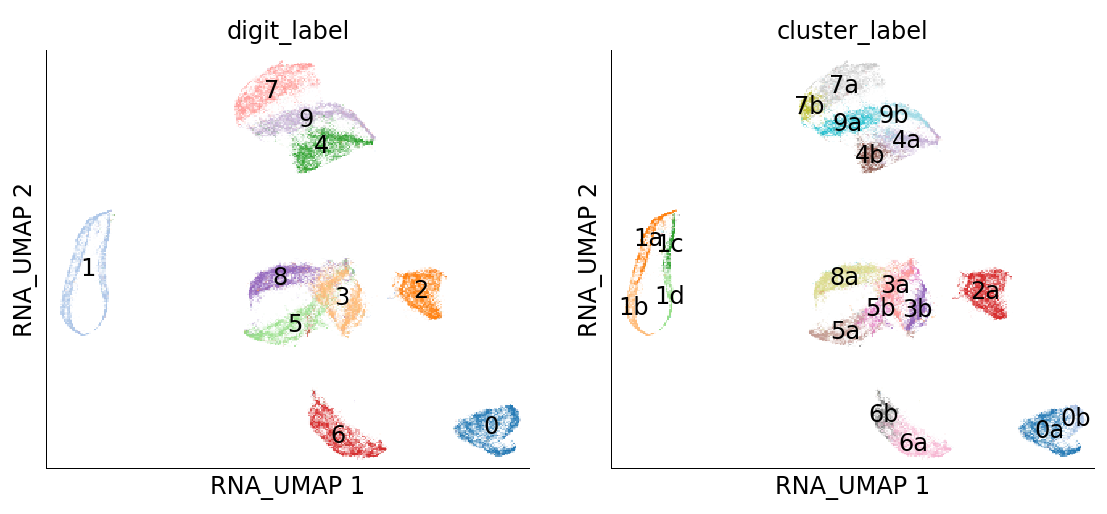

time: 4.75 s (started: 2021-08-02 18:01:50 +02:00)


In [10]:
ds.plot_layout(
    layout_key='RNA_UMAP', color_by=['digit_label', 'cluster_label'],
    do_shading=True, shade_npixels=300, legend_onside=False,
    width=4, height=4, cmap='tab20'
)

The UMAP embedding shows that images from the same individual digit classes were grouped together very nicely. We obtained a cluster of digits classes 4,7 and 9 and another of 3, 5 and 8 classses, similar observation has been made before in the link below. Since, the images from classes 0 and 1 are well separated once can infer that the global structure is also well preserved.

https://umap-learn.readthedocs.io/en/latest/auto_examples/plot_mnist_example.html

We can use `plot_cluster_tree` method to show an explicit realtionship between the clusters of images. This method leverages the hierarchical relationship between the individual images as calculated by the Paris algorithm. Each circle/pie (sized by number of images in the cluster) represents a clusters. The colurs inside each pie indicate the proportion actual digit classes.

Constructing graph from dendrogram:   0%|                                                                     …

Identifying the top node for cluster:   0%|                                                                   …

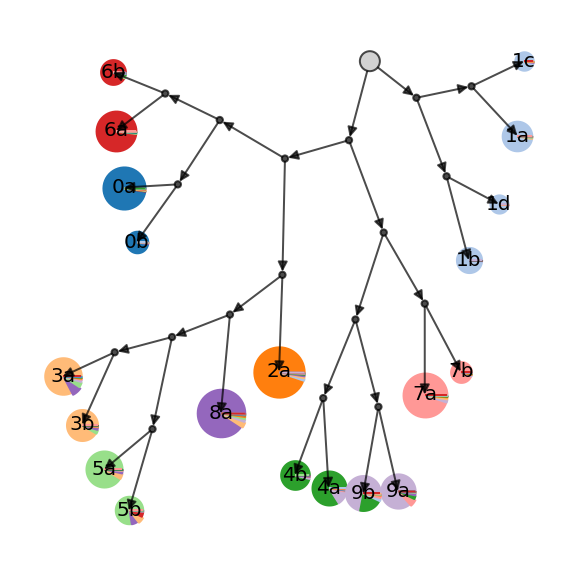

time: 2.92 s (started: 2021-08-02 18:01:54 +02:00)


In [11]:
ds.plot_cluster_tree(
    cluster_key='cluster_label',
    fill_by_value='digit_label',
)

Finally, lets visualize images from each of the cluster. To do so, we take all images from a given cluster and merge them (think of it can creating an overlay of all the images from that cluster).

In [12]:
clusts = pd.Series(ds.cells.fetch_all('cluster_label'))
digits = pd.Series(ds.cells.fetch_all('digit_label'))

time: 0 ns (started: 2021-08-02 18:01:57 +02:00)


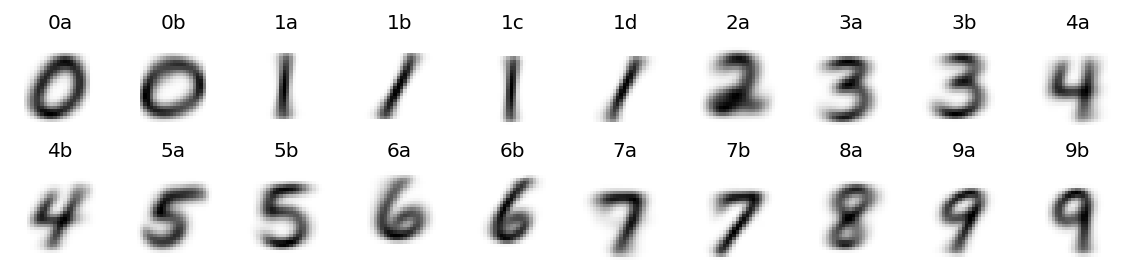

time: 3.08 s (started: 2021-08-02 18:01:57 +02:00)


In [13]:
fig = plt.figure(figsize=(8,2))
for n,i in enumerate(sorted(clusts.unique())):
    mean_map = ds.RNA.rawData[((clusts == i) & (digits == int(i[0]))).values].mean(axis=0)
    mean_map = mean_map.compute().reshape(28, 28)
    ax = fig.add_subplot(2, 10, n+1)
    ax.imshow(mean_map, cmap='binary')
    ax.set_axis_off()
    ax.set_title(i, fontsize=10)
plt.tight_layout()
plt.show()

It is quite clear that Scarf's clsutering was able to identify naunced differences between the images. For example, cluster 1a and 1c captured those images of an 'upright' 1s while cluster 1b and 1d captured 'slanted' 1s.

This vignette helped us learn two things:
- Scarf is a flexible package that can handle analysis of diverse kinds of datasets.
- Results from this dataset show that Scarf can perform quick, memory efficient and meaningful analysis of large-scale datasets.

---
That is all for this vignette.